# LLM agent with tool use

This is a sample notebook to demonstrate how tool use can improve the accuracy of an LLM.

## Setup

In [1]:
import os

from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

In [2]:
load_dotenv()

True

## Model

You will need a model that support tool use natively, such as [gpt-4o](https://openai.com/index/hello-gpt-4o/). You need an API key to use the model. Unfortunately, most of the LLM models are blocked or otherwise not supported in Hong Kong.

I have another notebook to demonstrate how to use tools with models that are weaker and does not natively support tools. It is much more of a hassle to do that.

In [3]:
llm = ChatOpenAI(
    base_url=os.getenv("OPENAI_API_ENDPOINT"),
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o",
    temperature=0,
)

## Define tools

The researcher will use a (web) search tool called [Tavily](https://tavily.com/), and the coder has a python REPL tool. You will need a `TAVILY_API_KEY` to use the Tavily tool.

In [4]:
python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description=(
        "A Python shell. Use this to execute python commands. Input should be a valid python command."
        " If you want to see the output of a value, you should print it out with `print(...)`. Always print the final output."
    ),
    func=python_repl.run,
)

tavily_tool = TavilySearchResults(max_results=2)

tools = [tavily_tool, repl_tool]

## Define agent

In [5]:
agent = create_react_agent(llm, tools=tools)

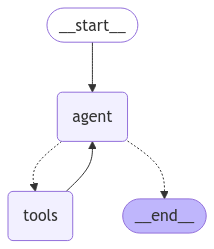

In [6]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

## Use cases

### 1. Simple arithmetic

It is well-known that LLM is bad in calculations. We will demonstrate it with the following example.

In [7]:
# the question
(81.0**0.33 - 5) * 13.27

-9.768953061571105

Note that invoking the LLM directly cannot solve this problem correctly.

In [8]:
direct_res = llm.invoke(
    "What is 81 raise to 0.33 power, subtract 5, and then multiply with 13.27?"
)
print(direct_res.content)

Let's break down the steps:

1. 81 raised to the power of 0.33 is approximately 3.929.

2. Subtract 5 from the above result: 3.929 - 5 = -1.071

3. Multiply the result by 13.27: -1.071 * 13.27 = -14.24157, which can be rounded to -14.24 (to 2 decimal places).

So, the final answer is approximately ** -14.24**.


but invoking the `python_repl` tool gives correct answer.

In [9]:
repl_tool.run("print((81 ** 0.33 - 5) * 13.27)")

Python REPL can execute arbitrary code. Use with caution.


'-9.768953061571105\n'

So, if the agent is able to use the `python_repl` tool:

In [11]:
for s in agent.stream({
        "messages": [("user", "What is 81 raise to 0.33 power, subtract 5, and then multiply with 13.27?")]
    }, 
    stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

What is 81 raise to 0.33 power, subtract 5, and then multiply with 13.27?
================================== Ai Message ==================================

I will calculate the value of 81 raised to the power of 0.33, then subtract 5, and finally multiply the result by 13.27.
Tool Calls:
  python_repl (python_repl0)
 Call ID: python_repl0
  Args:
    __arg1: # Calculating 81 raised to the power of 0.33
result = 81 ** 0.33

# Subtracting 5
result -= 5

# Multiplying by 13.27
result *= 13.27

print(result)
================================= Tool Message =================================
Name: python_repl

-9.768953061571105

================================== Ai Message ==================================

The answer to the calculation is approximately **9.77**.


The LLM gives the correct answer!

### 2. Composite problem

Using multiple tools give the LLM ability to solve more complex problems.

In [14]:
for s in agent.stream({
        "messages": [("user", "What is the age of Li Ka-Shing as of today raised to the 0.43 power?")]
    }, 
    stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

What is the age of Li Ka-Shing as of today raised to the 0.43 power?
================================== Ai Message ==================================

First, I will find out Li Ka-Shing's age. Then, I will use Python to calculate his age raised to the power of 0.43.
Tool Calls:
  tavily_search_results_json (tavily_search_results_json0)
 Call ID: tavily_search_results_json0
  Args:
    query: Li Ka-Shing's age
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://networthmirror.com/li-ka-shing-net-worth/", "content": "What is Li-Ka Shing's age? Li-Ka Shing, who is currently 94 years old, was born on July 29, 1928. What is Li-Ka Shing's height? Li-Ka Shing stands 1.73 m tall, or 5 feet 8 inches. Summary. The wealthiest person in China is Li-Ka Shing, and his business has influenced businesspeople and entrepreneurs around the worl